In [1]:
import scipy.io
import numpy as np
from collections import defaultdict
from scipy.sparse import dok_matrix

In [2]:
def findMaxIndex(mat, maxLength=None):
    size = 0
    for nset in mat['nodeSet'][0]:
        if maxLength:
            size = max(maxLength+1, size)
        else:
            size = max(np.max(nset.flatten())+1, size)
    return size

def convertToCluster(mat, maxLength=None):
    # label 0 are nodes ioslated or label paddings
    size = findMaxIndex(mat, maxLength)
    clusters = np.zeros(size)
    label = 1
    for nset in mat['nodeSet'][0]:
        clusters[nset.flatten()] = label
        label += 1
    return clusters

In [5]:
import os
out_dir = 'composite_cluster_outputs_all_85/'

clusters = []
for file in os.listdir(out_dir):
    if not file.endswith('mat'): continue
    path = out_dir + file
    mat = scipy.io.loadmat(path)
    clusters.append(convertToCluster(mat, maxLength=5245))
labels = np.array(clusters)
# np.save('composite_cluster_all_85', labels)
labels, labels.shape

(array([[ 0.,  1.,  0., ..., 11.,  0.,  0.],
        [ 0.,  2.,  0., ..., 11.,  0.,  0.],
        [ 0., 12.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  2.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  0., ...,  0.,  0.,  0.],
        [ 0.,  2.,  0., ..., 10.,  0.,  0.]]), (200, 5246))

In [6]:
def createLabelVector(labels):
    mruns, nsamples = labels.shape
    return [tuple(labels[:,i]) for i in range(nsamples)]

In [7]:
def countLabelVector(labelVectors):
    lv_dict = defaultdict(int)
    for lv in labelVectors:
        lv_dict[lv] += 1
    return lv_dict

In [8]:
def computeHammingDistance(t1, t2):
    return sum([t1[i] != t2[i] for i in range(len(t1))])

In [9]:
def most_common(lst):
    return int(max(((item, lst.count(item)) for item in set(lst)), key=lambda a: a[1])[0])

In [10]:
# create edges between label vector if the hamming distance is smaller than a threshold
# the weight of the edge is scaled to ampify the hamming distance effect
def createEdges(keys, dist=10, scaling=-10.0):
    n = len(keys)
    dokmat = dok_matrix((n, n))
    for i in range(n):
        for j in range(i+1, n):
            if (computeHammingDistance(keys[i], keys[j]) <= dist):
                dokmat[i,j] = np.exp((computeHammingDistance(keys[i], keys[j])-1)/scaling)
    return dokmat.tocoo()

# load existing label vectors

In [5]:
labels = np.load('composite_cluster_all_85.npy')
labels = labels.astype(int)
labels.shape

(20, 5246)

In [17]:
# labels = np.load('composite_cluster_outputs_CINMS_80.npy')
# labels = labels.astype(int)
# labels.shape

(500, 3845)

In [73]:
# row iterations, column samples
labels.shape

(108, 5246)

In [11]:
labels

array([[ 0.,  1.,  0., ..., 11.,  0.,  0.],
       [ 0.,  2.,  0., ..., 11.,  0.,  0.],
       [ 0., 12.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  2.,  0., ..., 10.,  0.,  0.]])

In [12]:
# how many different clusters do Kait's clustering algorithm give us each time?
counts = np.sort(labels,axis=1)
(counts[:,1:] != counts[:,:-1]).sum(axis=1)+1

array([14, 15, 14, 14, 14, 15, 13, 15, 14, 13, 14, 15, 14, 15, 13, 14, 14,
       15, 14, 14, 14, 14, 14, 15, 15, 15, 14, 15, 15, 14, 15, 14, 14, 15,
       15, 14, 14, 14, 15, 14, 15, 14, 15, 16, 15, 14, 15, 14, 15, 15, 15,
       14, 15, 15, 14, 14, 15, 15, 14, 15, 15, 15, 15, 13, 14, 15, 15, 15,
       15, 14, 13, 13, 14, 13, 14, 15, 14, 15, 14, 15, 14, 14, 14, 15, 14,
       13, 15, 15, 12, 14, 15, 14, 14, 16, 14, 15, 14, 15, 15, 13, 15, 14,
       14, 15, 15, 15, 15, 14, 15, 14, 15, 14, 15, 15, 14, 13, 14, 15, 14,
       15, 14, 14, 14, 14, 15, 14, 15, 15, 15, 14, 13, 13, 14, 15, 13, 14,
       14, 13, 15, 14, 15, 15, 15, 14, 15, 12, 14, 15, 13, 14, 14, 15, 15,
       14, 14, 15, 15, 15, 14, 14, 14, 15, 14, 15, 15, 13, 15, 15, 13, 15,
       15, 14, 14, 15, 15, 15, 15, 13, 14, 15, 15, 15, 14, 14, 15, 14, 14,
       12, 15, 14, 14, 14, 14, 14, 14, 15, 14, 14, 14, 15])

In [28]:
# 0s are paddings or without actual meaning
lv_dict = countLabelVector(createLabelVector(labels))
keys = list(lv_dict)
keys = list(filter(lambda key: most_common(key) != 0, keys))
len(keys)

34

In [32]:
coomat = createEdges(keys, dist=199, scaling=-199)

In [33]:
nodes = []
for i, key in enumerate(keys):
    nodes.append({'id': i, 
                  'r': lv_dict[key],
                  'group': most_common(key)
                 })
links = []
for i, j, v in zip(coomat.row, coomat.col, coomat.data):
    links.append({'source': int(i), 
                  'target': int(j),
                  'weight': v*10,
                 })

In [34]:
import json
with open('nodes.json', 'w') as f:
    json.dump(nodes, f)
with open('links.json', 'w') as f:
    json.dump(links, f)

Use the saved json files to visualize the effects:

https://observablehq.com/@jingwu010/force-directed-graph

In [31]:
links

[{'source': 0, 'target': 1, 'weight': 4.382349924649493},
 {'source': 0, 'target': 2, 'weight': 10.0},
 {'source': 0, 'target': 3, 'weight': 9.950124791926823},
 {'source': 0, 'target': 4, 'weight': 4.448580662229411},
 {'source': 0, 'target': 5, 'weight': 10.0},
 {'source': 0, 'target': 10, 'weight': 8.607079764250578},
 {'source': 0, 'target': 13, 'weight': 9.950124791926823},
 {'source': 0, 'target': 19, 'weight': 4.106557527523455},
 {'source': 0, 'target': 20, 'weight': 4.867522559599717},
 {'source': 0, 'target': 21, 'weight': 9.559974818331},
 {'source': 0, 'target': 23, 'weight': 4.382349924649493},
 {'source': 0, 'target': 25, 'weight': 3.9455371037160107},
 {'source': 0, 'target': 27, 'weight': 3.8098319973933723},
 {'source': 0, 'target': 28, 'weight': 9.950124791926823},
 {'source': 0, 'target': 29, 'weight': 4.252831910822741},
 {'source': 1, 'target': 2, 'weight': 4.404316545059993},
 {'source': 1, 'target': 3, 'weight': 4.360492863215356},
 {'source': 1, 'target': 4, 'we

In [36]:
nodes

[{'id': 0, 'r': 282, 'group': 2},
 {'id': 1, 'r': 53, 'group': 1},
 {'id': 2, 'r': 3, 'group': 2},
 {'id': 3, 'r': 249, 'group': 2},
 {'id': 4, 'r': 7, 'group': 1},
 {'id': 5, 'r': 2854, 'group': 4},
 {'id': 6, 'r': 71, 'group': 2},
 {'id': 7, 'r': 24, 'group': 9},
 {'id': 8, 'r': 184, 'group': 5},
 {'id': 9, 'r': 6, 'group': 2},
 {'id': 10, 'r': 100, 'group': 9},
 {'id': 11, 'r': 113, 'group': 7},
 {'id': 12, 'r': 1, 'group': 2},
 {'id': 13, 'r': 125, 'group': 6},
 {'id': 14, 'r': 1, 'group': 4},
 {'id': 15, 'r': 267, 'group': 11},
 {'id': 16, 'r': 1, 'group': 11},
 {'id': 17, 'r': 1, 'group': 1},
 {'id': 18, 'r': 2, 'group': 2},
 {'id': 19, 'r': 178, 'group': 8},
 {'id': 20, 'r': 1, 'group': 1},
 {'id': 21, 'r': 26, 'group': 10},
 {'id': 22, 'r': 33, 'group': 13},
 {'id': 23, 'r': 84, 'group': 12},
 {'id': 24, 'r': 12, 'group': 2},
 {'id': 25, 'r': 2, 'group': 12},
 {'id': 26, 'r': 3, 'group': 8},
 {'id': 27, 'r': 2, 'group': 5},
 {'id': 28, 'r': 3, 'group': 8}]

In [51]:
hamming_distances = []
n = len(keys)
for i in range(n):
    for j in range(i, n):
        hamming_distances.append(computeHammingDistance(keys[i], keys[j]))

In [52]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


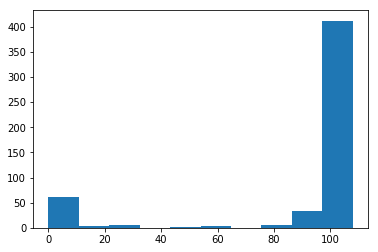

In [54]:
hist(hamming_distances);